In [1]:
import os
import sys
import scanpy as sc
import pandas as pd

from langchain_openai import ChatOpenAI

sys.path.append(os.path.abspath('.'))
from cellhashtag.utils import *
from cellhashtag._Agent import CellHashtagAgent

### Setup LLM
##### Currently, only LLMs that use the OpenAI API are supported. Supported vendors include openAI, [Dashscope (Alicloud)](https://dashscope.aliyun.com/), [Siliconflow](https://www.siliconflow.com/en/home), Ollama, DeepSeek etc.

In [ ]:
#setup LLMs
#BGI的同学请咨询智能所的老师获取免费deepseek API
llm_api_key = ""  #put your api key here
llm_api_base = "" #put your api url base here
model_name = "" #select your model here
llm = call_chatllm_openai(llm_api_key, llm_api_base)

## Setup webscraper
##### Currently we only use Tavily for fast web crawling, and you guys can get 1000 free searches credits per month through the official site of [Tavily AI](https://tavily.com/) !
##### Cell# can run without online information, but Annotation performance will depend greatly on the LLM you use!

In [4]:
#setup webscraper
tavily_api = "" #put your Tavily api here
#test webscraper
if tavily_api != "":
    web_retriever = set_web_scraper(tavily_api)
    web_res = web_retriever.invoke("What is AI agent")
    print("Each time the scraper fetch",len(web_res),"pages, page example as:\n")
    print(web_res[0])

### Load example data

In [4]:
#!!!IMPORTANT Note!!!
# please double check if .h5ad filed successfully downloaded, it stored with Git LFS  ʅ（´◔౪◔）ʃ
#after you cloned the git repo, please: 
#   1.install git-lfs(from sudo/brew etc), then 
#   2.go to the main folder and use command "git lfs install", 
#   3.after Git LFS setted, pull the .h5ad file use "git lfs pull"
#
#the .h5ad file size shoud be 447,143KB
adata = sc.read_h5ad('cellhashtag/data/example.h5ad')
adata

#Note
#If you wanna use your own data, please do QC, de-bach and calculate cluster before use Cell# (ง๑ •̀_•́)ง

AnnData object with n_obs × n_vars = 2574 × 35899
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'leiden', 'Organism', 'tissue', 'diease'
    var: 'Ensemble', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'celltypist_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'singleR_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

##### [Optinal], use prior knowledge for cell markers（a compatibility solution for now)

In [ ]:
#Optional
#the cell markers df is pre collected by human, Cell# will collect cell markers from website if web scraper ready,
#you can also make your own cell marker table, make sure contain "cell_type" and “cell_markers" columns, like the example one
cell_markers_df = pd.read_csv('cellhashtag/data/example_cellmarkers.csv',index_col=0)
print('Check cell markers dataframe:')
cell_markers_df
#I know this format is not standarized, It's just a compatibility solution, later we'll replace DataFrame with KG 

Check cell markers dataframe:


,cell_type,cell_markers
0,Enterocytes,"['ANPEP', 'CA1', 'CA2']"
1,Goblet cells,"['MUC2', 'FCGBP', 'BCAS1', 'REG4', 'SPINK4', '..."
2,Enteroendocrine cells,"[""CHGA"", ""SYP"", ""TPH1"", ""GAST"", ""SST"", ""GCG"", ..."
3,Stem cells,"[""CD34"", ""CD133"", ""LGR5"", ""POU5F1"", ""ZFP42""]"
4,Tuft cells,"['DCLK1', 'PTGS1', 'CHAT', 'VIL1', 'PLS1']"
5,Fibroblasts,"[""VIM"", ""PDGFRA"", ""COL1A1"", ""COL3A1"", ""DCN"", ""..."
6,Endothelial cells,"['CD31', 'CD34', 'CD105', 'VE-cadherin', 'vWF'..."
7,T cells,"[""CD3D"", ""CD3E"", ""CD3G"", ""CD4"", ""CD8A"", ""CD8B""..."
8,B cells,"['CD19', 'MS4A1', 'CD20', 'CR2', 'CD21', 'PTPRC']"
9,Plasma cells,"['SDC1', 'CD38', 'CD27', 'CD24', 'TNFRSF17', '..."


### Run Cell# agent

In [5]:
#1. Initialate Cell# agent
agent = CellHashtagAgent(
    web_scraper_api_key = tavily_api, # you can set the tavily_api = None if you dont wann use web scraper
    web_scraper = 'Tavily', #defualt is Tavily, we don't provide any other web scraper now, (˘•ω•˘) sorry
    #following optinal 
    k_web_res = 7, #number of web pages to fetch for each cell type marker web search query
    max_retry = 3, #maxium retry times for each agent node
    )

Initializing Cell# Agent
Web scraper ready.
Subgraph ready
Cell# agent ready.


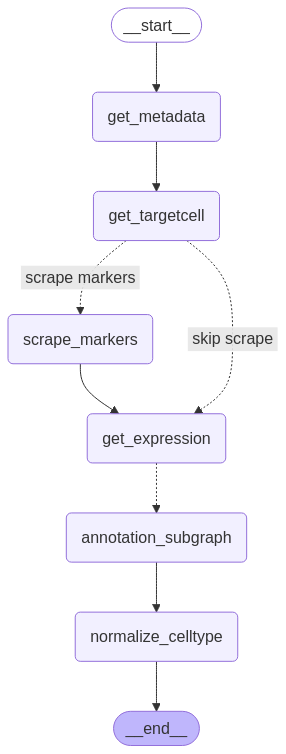

In [ ]:
#You can peak the agent cognitive architecture by draw the agent graph 
#this may get **ConnectionError** error with no reason (´;ω;`), you can try multiple times to plot the graph 
draw_graph(agent.graph)

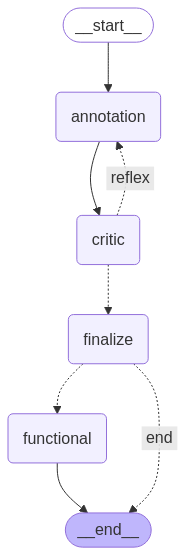

In [9]:
#Also the annotation subgraph
draw_graph(agent.subgraph)

Getting summary of given data...
given data is <class 'anndata._core.anndata.AnnData'>
Looking for target cell types for annotation...
Recommended annotation target cell types are:
Epithelial cells
Immune cells
Stromal cells
Endothelial cells

Cell marker dataframe loaded.
Scraping cell markers...
Trying to fetch cell markers for Epithelial cells from web.
Trying to fetch cell markers for Immune cells from web.
Trying to fetch cell markers for Stromal cells from web.
Trying to fetch cell markers for Endothelial cells from web.
Cell type and marker list saved to csv.
Getting data gene expressing summary...
Calling subgraph for annotation...
Calling subgraph for annotation...
Calling subgraph for annotation...
Calling subgraph for annotation...
Calling subgraph for annotation...
Calling subgraph for annotation...
Calling subgraph for annotation...
Annotating cluster 11...
Calling subgraph for annotation...
Annotating cluster 5...
Calling subgraph for annotation...
Calling subgraph for an

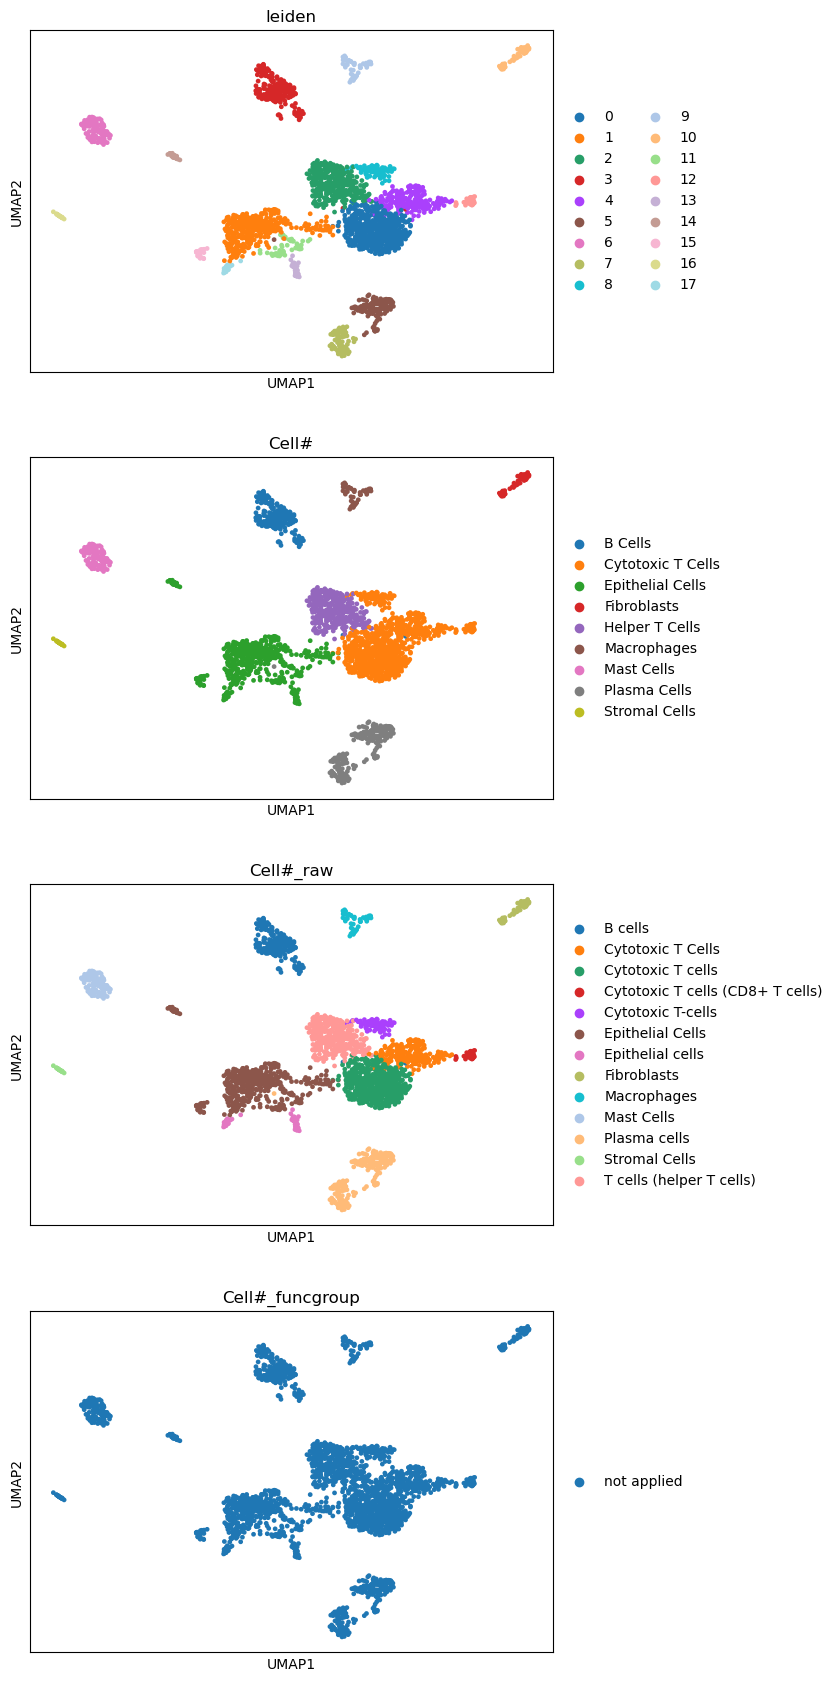

In [6]:
#2. Run the Cell# agnet, and wait... wait... _(¦3」∠)_   It takes about ~5-10mins depends on the difficulty of annotation(self-critic rounds) and the speed of your LLM
#You can observe the agent's behavior by the output states, and the annotated data will be save to local filed named "annotated_data.h5ad" 
output_states = agent.run(
                        #Parameters musch be provided
                        llm=llm,  
                        adata= adata,
                        cluster_key = "leiden", #default is "leiden", you can change to other cluster key
                        #Optional Parameters
                        cell_marker_df_dir = 'cellhashtag/data/example_cellmarkers.csv', #please give the cell marker table file dir, and if this provided, will skip online marker crawling
                        plot_annotation = True,
                        max_iter = 5, #max round of self-critic annotation, default is 5
                        #thread_id: str = '1', #thread id for the agent memory, you don't need to change it
                        )

In [7]:
#3. Done (´▽`ʃ♡ƪ)"
#You can load auto saved annotated AnnData file from... 
adata = sc.read_h5ad('Annotated_adata.h5ad')
#or you can also use pickle to load from temp... 
# with open("input_adata_temp.pkl", "rb") as f:
#     adata = pickle.load(f)
adata

AnnData object with n_obs × n_vars = 2574 × 35899
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'leiden', 'Organism', 'tissue', 'diease', 'Cell#', 'Cell#_raw', 'Cell#_funcgroup'
    var: 'Ensemble', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'celltypist_colors', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'singleR_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'